In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get stock data

In [181]:
import os
from dotenv import load_dotenv
load_dotenv()

API_KEY = os.getenv("ALPACA_API_KEY")
SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")

In [182]:
TICKER = "AAPL"

In [192]:
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

client = StockHistoricalDataClient(API_KEY, SECRET_KEY)
request_params = StockBarsRequest(
    symbol_or_symbols=TICKER,
    timeframe=TimeFrame.Day,
    start=datetime(2020, 1, 1),
    end=datetime(2024, 12, 31)
)

bars = client.get_stock_bars(request_params)
df = bars.df

# Feature engineering

In [193]:
df.reset_index(inplace=True)
df.drop(columns=['symbol'], inplace=True)


In [194]:
df["close_lag_1"] = df["close"].shift(1)
df["close_lag_2"] = df["close"].shift(2)

df["open_lag_1"] = df["open"].shift(1)
df["open_lag_2"] = df["open"].shift(2)

df["high_lag_1"] = df["high"].shift(1)
df["high_lag_2"] = df["high"].shift(2)

df["low_lag_1"] = df["low"].shift(1)
df["low_lag_2"] = df["low"].shift(2)

df["volume_lag_1"] = df["volume"].shift(1)
df["volume_lag_2"] = df["volume"].shift(2)

In [195]:
import talib as ta

df["RSI_14"] = ta.RSI(df["close"], timeperiod=14)
df["SMA_20"] = ta.SMA(df["close"], timeperiod=20)
df["SMA_50"] = ta.SMA(df["close"], timeperiod=50)
df["Bollinger_High"] = ta.BBANDS(df["close"], timeperiod=20, nbdevup=2, nbdevdn=2)[0]
df["Bollinger_Low"] = ta.BBANDS(df["close"], timeperiod=20, nbdevup=2, nbdevdn=2)[2]
df["MACD"] = ta.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)[0]
df["RSI_14"] = ta.RSI(df["close"], timeperiod=14)


In [197]:
import finnhub as fh

fh_client = fh.Client(api_key=os.getenv("FINNHUB_API_KEY"))
earnings = fh_client.company_earnings(symbol=TICKER)

for earning in earnings:
    quarter = earning['quarter']
    year = earning['year']

    df["earnings_estimate"] = np.where(
        (df["timestamp"].dt.year == year) & (df["timestamp"].dt.quarter == quarter),
        earning['estimate'],
        np.nan
    )

    df["earnings_actual"] = np.where(
        (df["timestamp"].dt.year == year) & (df["timestamp"].dt.quarter == quarter),
        earning['actual'],
        np.nan
    )

    df["earnings_surprise"] = np.where(
        (df["timestamp"].dt.year == year) & (df["timestamp"].dt.quarter == quarter),
        earning['surprise'],
        np.nan
    )
    

In [201]:
df["is_up"] = (df["close"] > df["open"]).astype(int)
df.dropna(inplace=True)

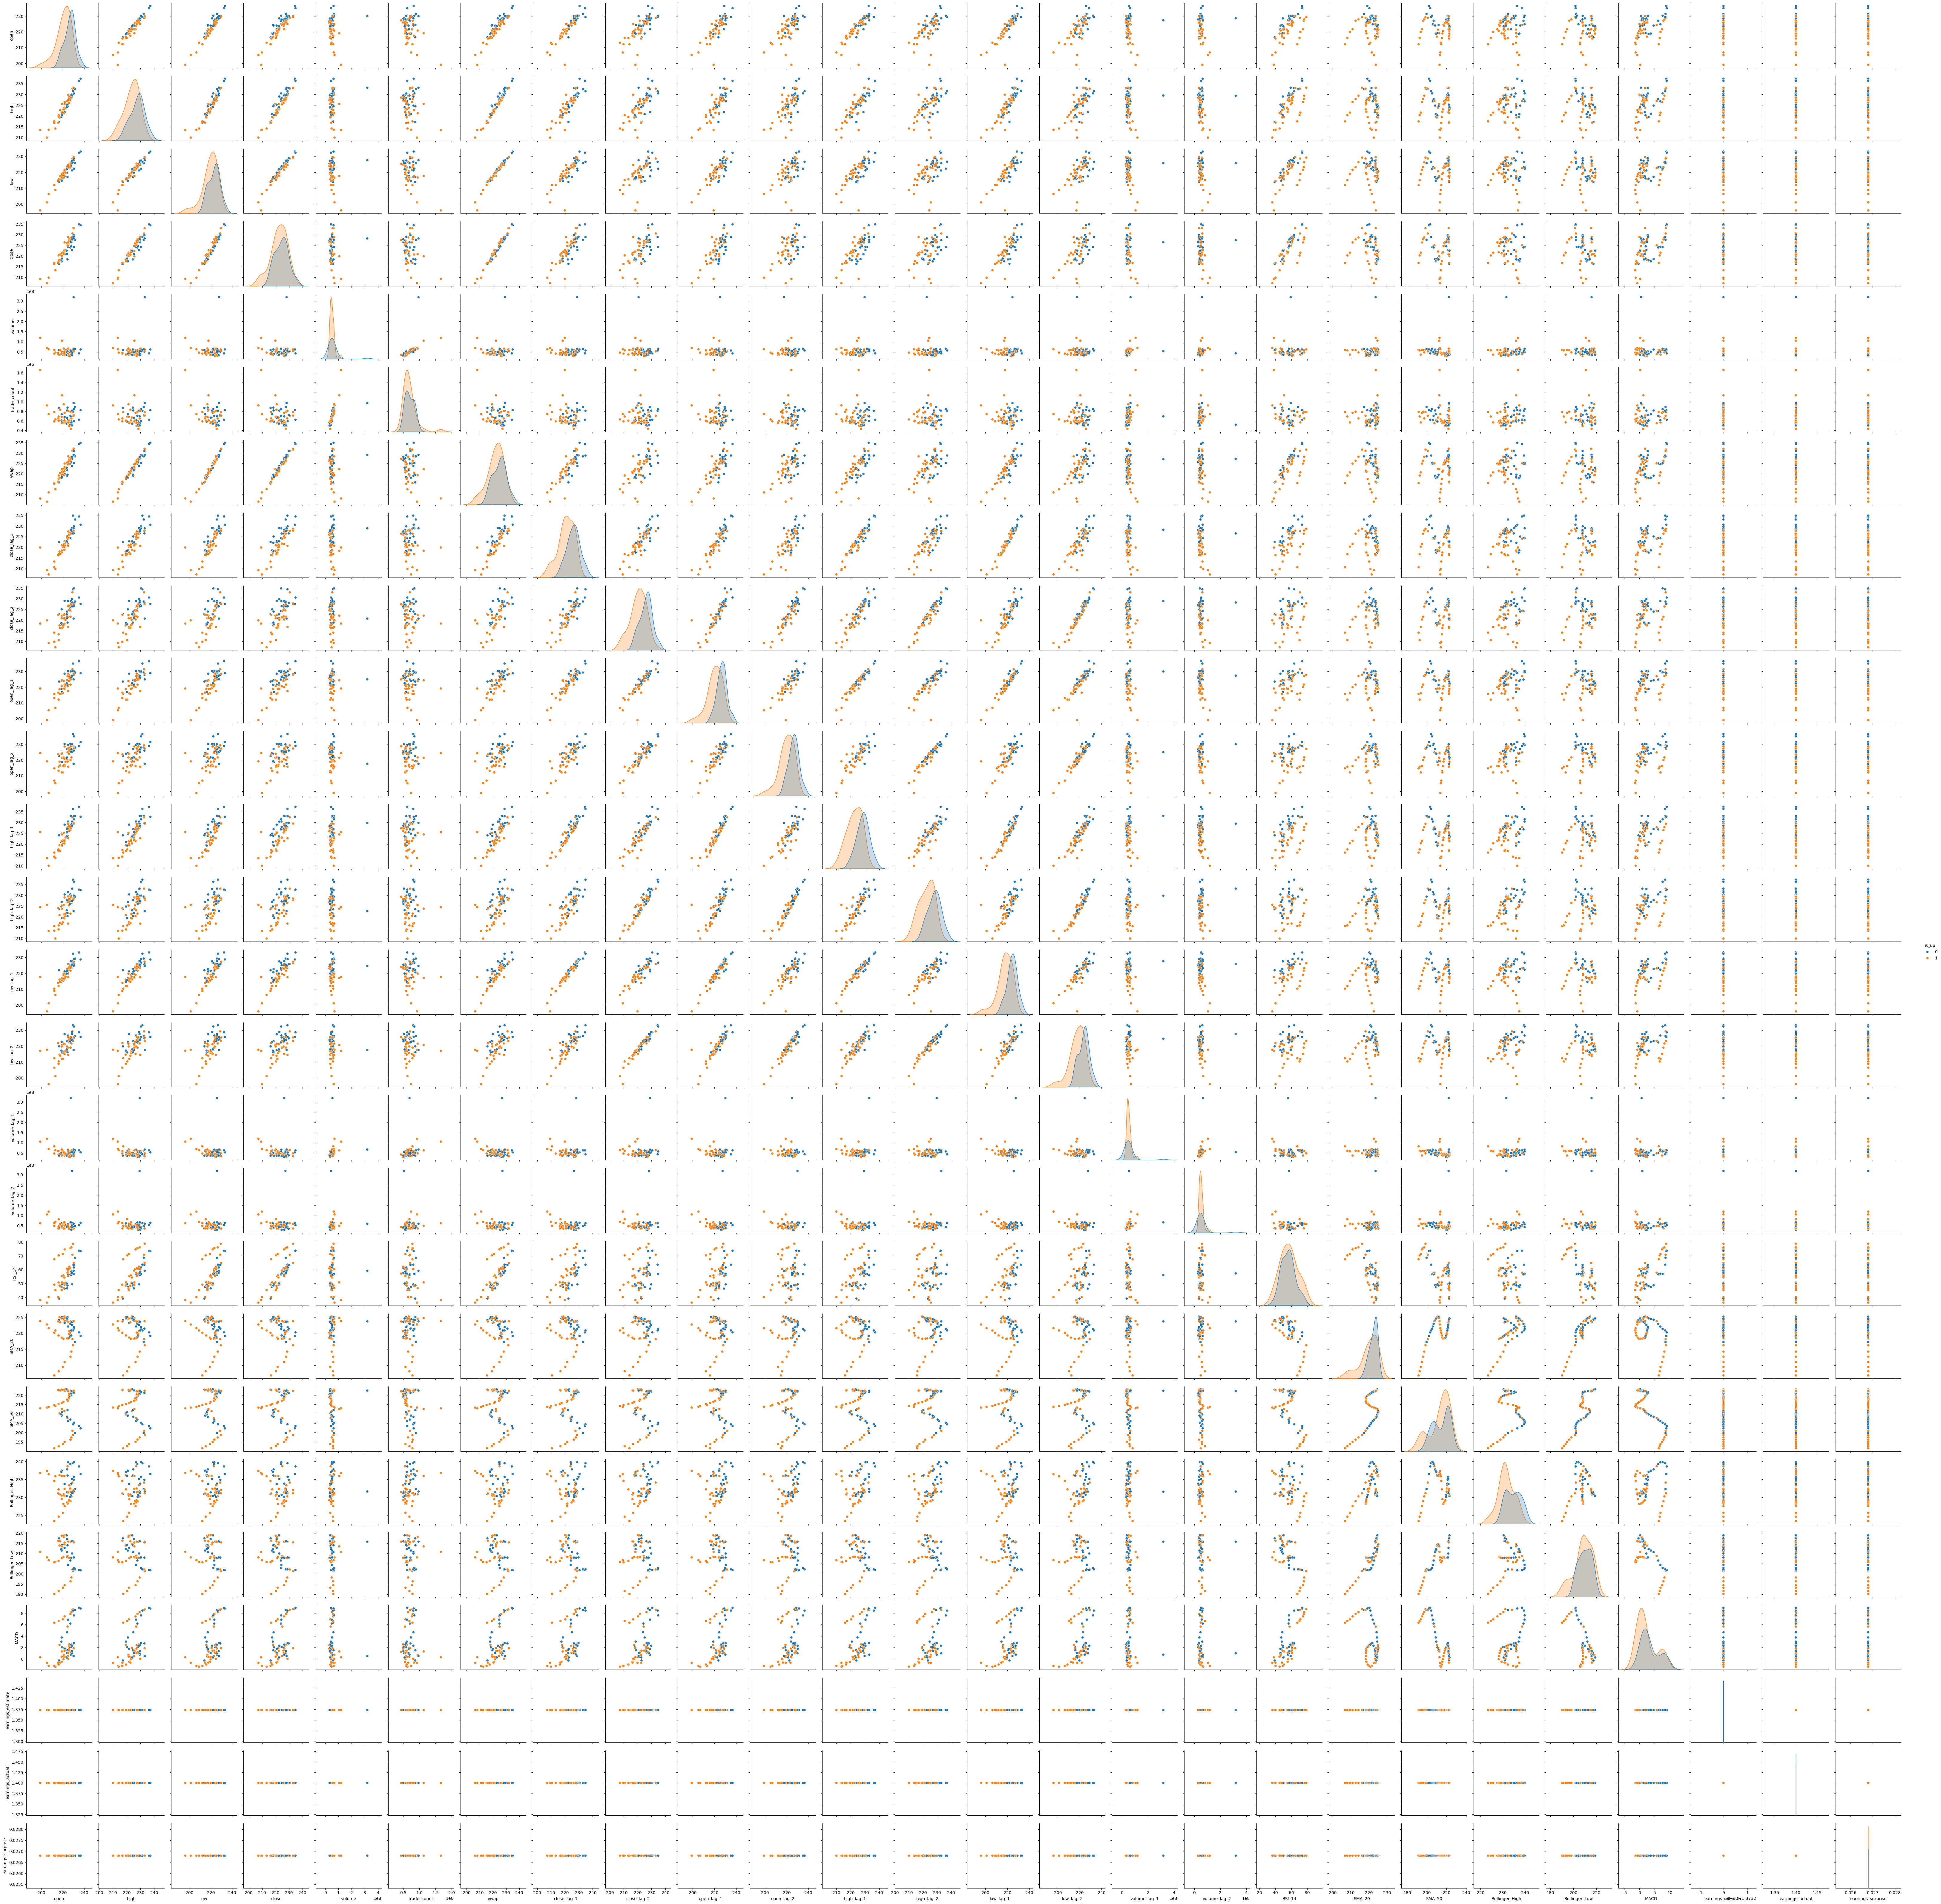

In [202]:
sns.pairplot(df, hue="is_up")

# Build & train model

In [203]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['timestamp', 'is_up'])
y = df['is_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# y_pred = rf.predict(X_test)
y_pred = xgb.predict(X_test)

In [205]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6923076923076923


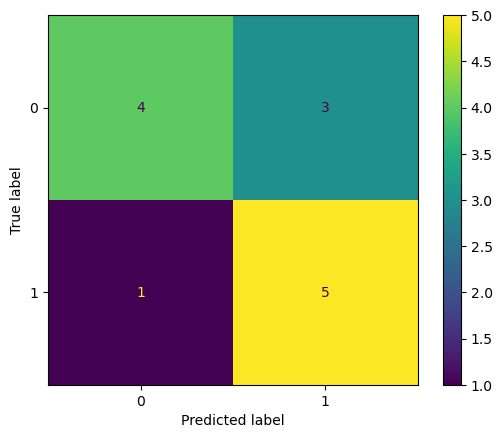

In [206]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();